In [1]:
library(tidyverse)
library(hrbrthemes)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'hrbrthemes' was built under R version 4.1.3"


In [2]:
# read file and add under weight

under <- read.csv("C:\\Users\\Elena.Mariani\\Documents\\Projects\\ahl_weight_loss_modelling\\Data\\calorie_deficit_scenarios_w_imd.csv", sep = ",", fileEncoding="UTF-8-BOM") %>% 
  filter(BMI_class == "underweight") %>% 
  mutate(finalWeight = Wt_est,
         startWeight = Wt_est,
         height = Ht_est,
         age = Age_est,
         Sex_letter = ifelse(Sex == "female", "F", "M"),
         sex = Sex_letter,
         baseIntake = ifelse(sex == "M", -.0971*(Wt_est^2) + 40.853*Wt_est + 323.59, .0278*(Wt_est^2) + 9.2893*Wt_est + 1528.9),
         newIntake = baseIntake,
         TEE_final = baseIntake,
         weight_final = Wt_est,
         intake_final = newIntake,
         bmi_final = BMI_est,
         value = 0,
         target = Wt_est,
         calRed = 0)

full <- plyr::rbind.fill(under, read_csv("C:\\Users\\Elena.Mariani\\Documents\\Projects\\ahl_weight_loss_modelling\\Output\\hse_full_weight_loss.csv")) %>% 
  mutate(BMI_class = case_when(BMI_est <= 18.5 ~ "underweight",
                               BMI_est > 18.5 & BMI_est < 25 ~ "normal",
                               BMI_est >= 25 & BMI_est < 30 ~ "overweight",
                               BMI_est >= 30 ~ "obese",
                               TRUE ~ "NA")) %>% 
  mutate(final_BMI_class = case_when(bmi_final <= 18.5 ~ "underweight",
                                     bmi_final > 18.5 & bmi_final < 25 ~ "normal",
                                     bmi_final >= 25 & bmi_final < 30 ~ "overweight",
                                     bmi_final >= 30 ~ "obese",
                                     TRUE ~ "NA"))

Rows: 7620 Columns: 39

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (7): sex, BMI_class, Sex, Age_group, Ethnicity, Sex_letter, final_BMI_c...
dbl (31): X, time, f, FFM, finalWeight, startWeight, height, age, baseIntake...
lgl  (1): thisMin


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [3]:
# read validation file

valid <- read_csv("C:\\Users\\Elena.Mariani\\Documents\\Projects\\ahl_weight_loss_modelling\\Data\\validation.csv")  %>% rename(X = ID)

Rows: 20 Columns: 9

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (1): sex
dbl (8): ID, weight, height, age, weight_tgt, days, Hall_TEE0, Hall_TEE1


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
# merge files
merged <- merge(valid, full, by = c("X"))

In [5]:
head(merged)

,X,weight,sex.x,height.x,age.x,weight_tgt,days,Hall_TEE0,Hall_TEE1,Sex,...,RMR,PA,SPA,DIT,EExp,diff,thisMin,cum,day_final,final_BMI_class
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>
1,549,64.0,M,170.18,77,60.27470,456.2500,2127,1993,female,...,1130.420,101.63758,496.6485,140.6919,1869.398,6.493749,FALSE,1,547.5000,normal
2,1001,67.4,M,167.00,47,63.47680,547.5000,2385,2245,male,...,1462.473,0.00000,527.6384,161.9544,2152.065,7.325972,FALSE,1,547.5000,normal
3,1064,72.5,M,173.80,37,68.27994,577.9167,2614,2471,female,...,1427.339,0.00000,510.7487,158.0135,2096.101,10.745891,FALSE,1,912.5000,obese
4,1780,54.8,F,157.00,42,52.43279,517.0833,1858,1768,male,...,1863.431,92.97364,729.3130,218.5987,2904.317,10.333031,FALSE,1,790.8333,overweight
5,2740,70.2,F,160.80,52,64.88181,699.5833,2063,1923,male,...,1465.169,246.77502,607.4642,188.6604,2508.069,7.403925,FALSE,1,608.3333,normal
6,3746,68.7,F,164.40,67,63.49544,669.1667,1957,1803,female,...,1240.683,93.44097,549.7173,153.4244,2037.266,8.391991,FALSE,1,608.3333,normal


In [6]:
reshape <- merged  %>% 
select(Sex, Age_est, BMI_class, BMI_est, startWeight, baseIntake, newIntake, Hall_TEE0, Hall_TEE1)  %>% 
reshape2::melt(., id.vars = c("startWeight", "Sex", "Age_est", "BMI_class", "BMI_est"))  %>% 
mutate(type = ifelse(variable %in% c("baseIntake", "Hall_TEE0"), "Baseline", "Final"))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



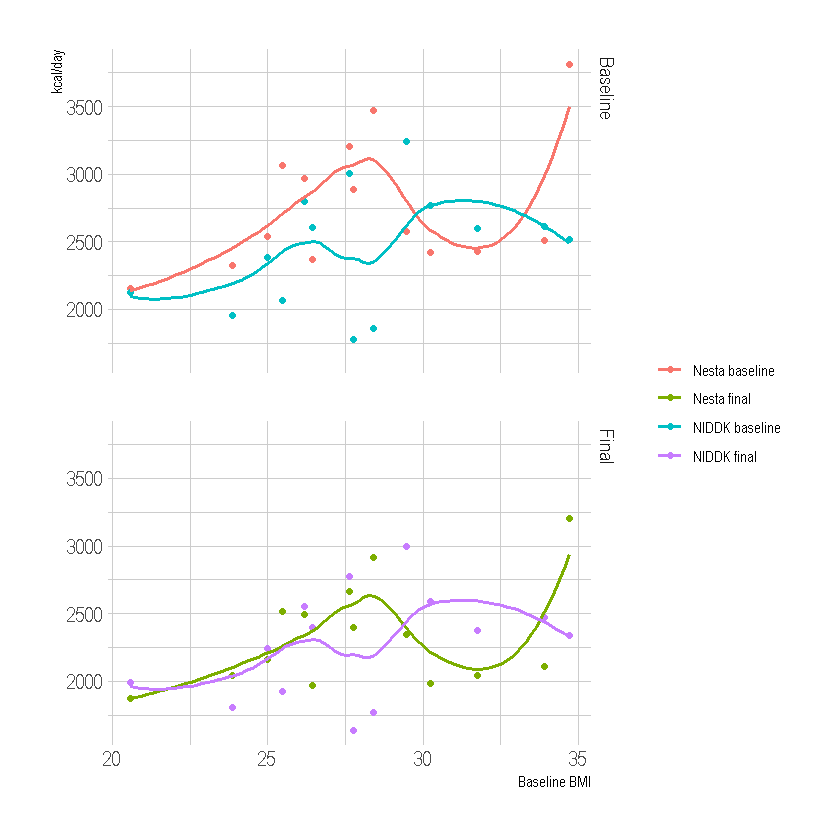

In [7]:
reshape  %>% 
mutate(label = case_when(variable == "baseIntake" ~ "Nesta baseline",
                         variable == "newIntake" ~ "Nesta final",
                         variable == "Hall_TEE0" ~ "NIDDK baseline",
                         TRUE ~ "NIDDK final"))  %>% 
ggplot(., aes(x = BMI_est, y = value, colour = label)) + 
geom_point() + 
geom_smooth(se = F) +
facet_grid(type ~ .) +
theme_ipsum() +
labs(x = "Baseline BMI", 
     y = "kcal/day",
    colour = "")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



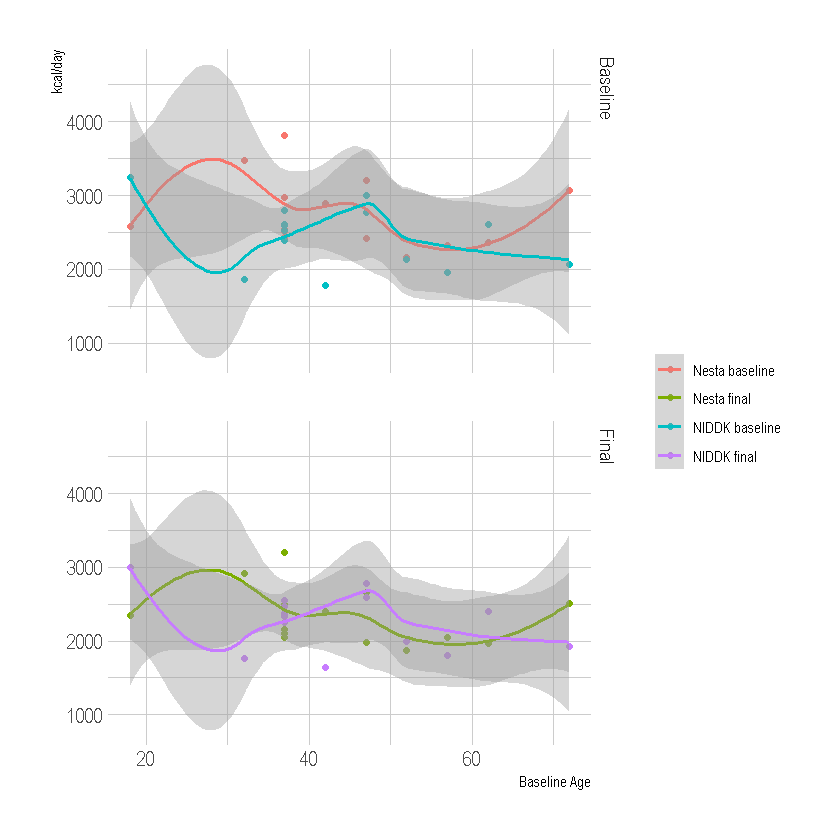

In [8]:
reshape  %>% 
mutate(label = case_when(variable == "baseIntake" ~ "Nesta baseline",
                         variable == "newIntake" ~ "Nesta final",
                         variable == "Hall_TEE0" ~ "NIDDK baseline",
                         TRUE ~ "NIDDK final"))  %>% 
ggplot(., aes(x = Age_est, y = value, colour = label)) + 
geom_point() + 
geom_smooth() +
facet_grid(type ~ .) +
theme_ipsum() +
labs(x = "Baseline Age", 
     y = "kcal/day",
    colour = "")